<a href="https://colab.research.google.com/github/Kryvkodenis/Segmentation_HW/blob/master/Copy_of_%5Bhw%5Dsemantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>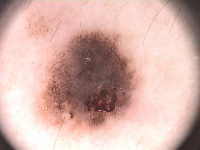</td><td>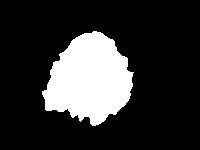</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -q /content/drive/My\ Drive/SegmentHW/PH2Dataset.zip -d PH2Dataset

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [0]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [0]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [41]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

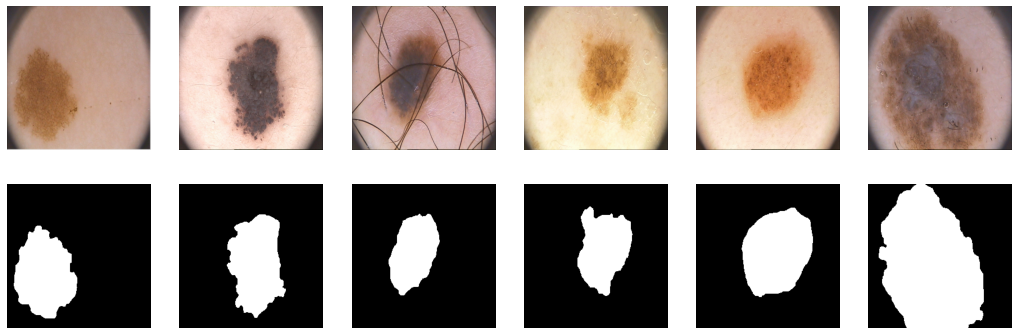

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap='gray')
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [42]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [0]:
def seed_torch(seed=1029):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [0]:
import numpy as np
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [0]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [0]:
from torch.utils.data import DataLoader
batch_size = 30
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

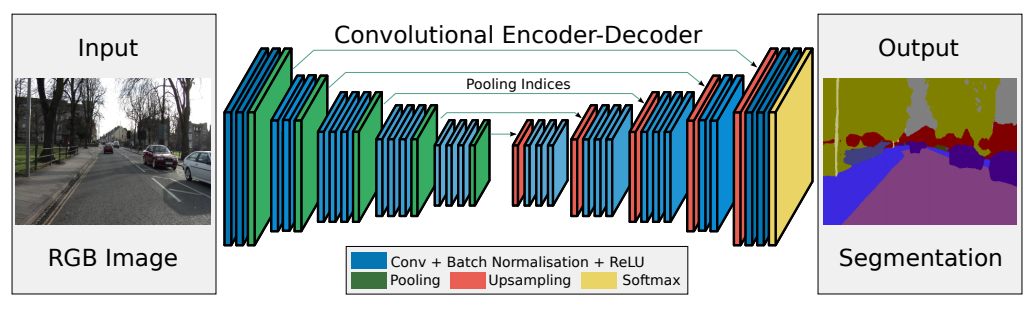

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [0]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                      )
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
        self.enc_conv2 =  nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, 3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, 3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())
        
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.pool3 = nn.MaxPool2d(2)  # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(256, 64, 1),
                                             nn.ReLU(),
                                             nn.Conv2d(64, 64, 3, padding=1),
                                             nn.ReLU(),
                                             nn.Conv2d(64, 256, 1))

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32, mode='bilinear')  # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        
        self.upsample1 = nn.Upsample(64, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
        self.upsample2 = nn.Upsample(128, mode='bilinear')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.upsample3 = nn.Upsample(256, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16, 1, 3, padding=1))


    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)
        b = F.relu(b)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [0]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [0]:
def bce_loss(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    loss = 0
    
    l = - y_pred * y_real + torch.log(1 + torch.exp(y_pred))
    loss = torch.mean(l)
    
    return loss

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [0]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            #print(loss.item(), len(data_tr))
            avg_loss += loss.item() / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)


        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0]>0.0, cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [0]:
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
      Y_pred = model(data.to(device))
    
    return Y_pred

In [0]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        scores += metric(Y_pred>0.0, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [0]:
def seed_torch(seed=1029):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [0]:
model = SegNet().to(device)

In [0]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

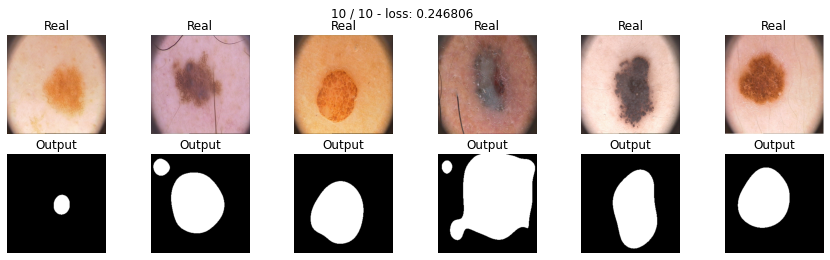

In [60]:
max_epochs = 10
train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model, iou_pytorch,data_val)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6483333309491476

In [0]:
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [0]:
def dice_loss(y_real, y_pred):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = torch.sigmoid(y_pred)
   
    num = 2 * torch.sum(y_pred * y_real) 
    den =  torch.sum(y_pred + y_real) 
    res = 1 - (num / (den))
    return res 

Проводим тестирование:

In [0]:
def seed_torch(seed=1029):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

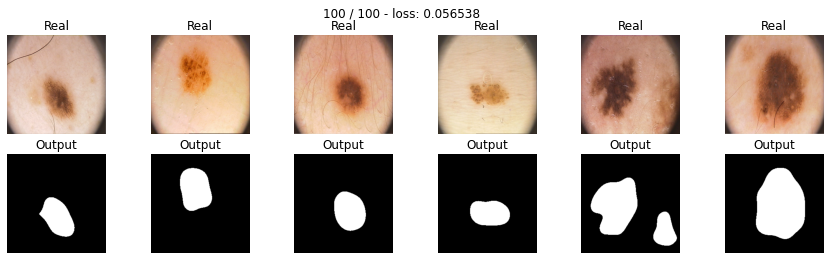

In [0]:
model_dice = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_dice.parameters(), lr=1e-3)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_dice, iou_pytorch, data_ts)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [0]:
def seed_torch(seed=1029):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [0]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    frame = lambda y: torch.clamp(torch.sigmoid(y), min=0+eps, max=1-eps)
    your_loss = torch.pow(1-frame(y_pred), gamma) * y_real * torch.log(frame(y_pred)) + (1 - y_real) * torch.log(frame(1 - y_pred))
    return - torch.mean(your_loss)


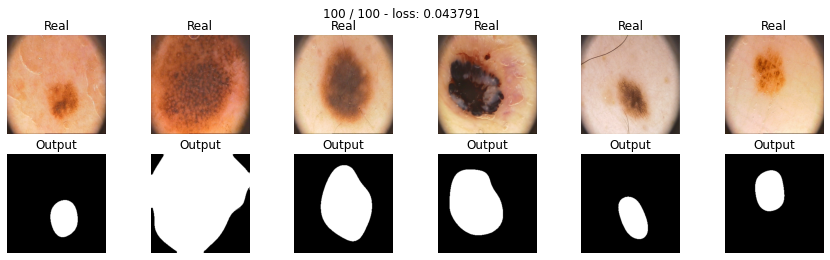

In [0]:
model_focal = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_focal, iou_pytorch, data_ts)

In [0]:
torch.cuda.empty_cache()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

**P.S.** *Сравнение функций потерь в выводе*

In [0]:
def Tversky_loss(y_real, y_pred, alpha=0.35, beta = 0.65):
    y_real = y_real.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = torch.sigmoid(y_pred)
   
    num = torch.sum(y_pred * y_real) 
    den =  torch.sum(y_pred * y_real) + alpha*torch.sum(y_pred * (1-y_real) ) + beta*torch.sum((1 - y_pred)*y_real)
    res = torch.mean(num / den)
    return 1 - res


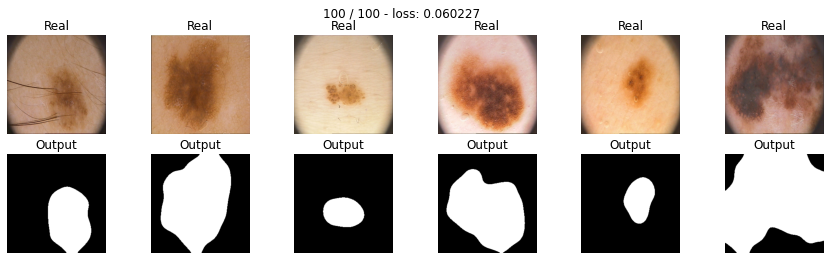

In [0]:
model_tversky = SegNet().to(device)

max_epochs = 20
optimaizer = optim.Adam(model_tversky.parameters())
train(model_tversky, optimaizer, Tversky_loss, max_epochs, data_tr, data_val)

In [0]:
score_model(model_tversky, iou_pytorch, data_ts)

In [0]:
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

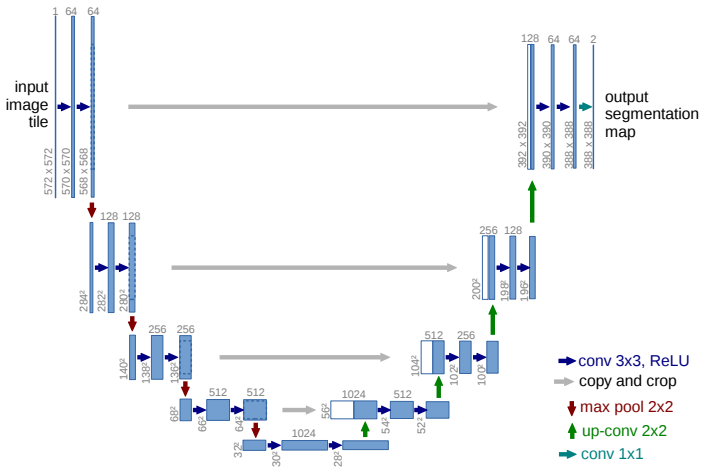

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [0]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    # encoder (downsampling)
    self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU()
                                  )
    self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
    self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
    self.pool1 = nn.MaxPool2d(2)  # 128 -> 64
    self.enc_conv2 =  nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
    
    self.pool2 = nn.MaxPool2d(2)  # 64 -> 32
    self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, 3, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, 3, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
    
    self.pool3 = nn.MaxPool2d(2)  # 32 -> 16


    # bottleneck
    self.bottleneck_conv = nn.Sequential(nn.Conv2d(256, 64, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(64, 64, 3, padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(64, 256, 1))

    # decoder (upsampling)
    self.upsample0 = nn.Upsample(32, mode='bilinear')  # 16 -> 32
    self.dec_conv0 = nn.Sequential(nn.Conv2d(256 + 256, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
    
    self.upsample1 = nn.Upsample(64, mode='bilinear') # 32 -> 64
    self.dec_conv1 = nn.Sequential(nn.Conv2d(128 + 128 , 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
    
    self.upsample2 = nn.Upsample(128, mode='bilinear')  # 64 -> 128
    self.dec_conv2 = nn.Sequential(nn.Conv2d(64 + 64, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
    self.upsample3 = nn.Upsample(256, mode='bilinear')  # 128 -> 256
    self.dec_conv3 = nn.Sequential(nn.Conv2d(32 + 32, 16, 3, padding=1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 1, 3, padding=1))


  def forward(self, x):
      # encoder
      e0_0 = self.enc_conv0(x)
      e0_1 = self.pool0(e0_0)     
      e1_0 = self.enc_conv1(e0_1)
      e1_1 = self.pool1(e1_0)     
      e2_0 = self.enc_conv2(e1_1)
      e2_1 = self.pool2(e2_0)     
      e3_0 = self.enc_conv3(e2_1)
      e3_1 = self.pool3(e3_0)     

      # bottleneck
      b = self.bottleneck_conv(e3_1)
      b = F.relu(b)

      # decoder
      d0 = self.upsample0(b)
      d0 = torch.cat((e3_0, d0), dim=1)    
      d0 = self.dec_conv0(d0)
      d1 = self.upsample1(d0)
      d1 = torch.cat((e2_0, d1), dim=1)    
      d1 = self.dec_conv1(d1)
      d2 = self.upsample2(d1)
      d2 = torch.cat((e1_0, d2), dim=1)    
      d2 = self.dec_conv2(d2)
      d3 = self.upsample3(d2)
      d3 = torch.cat((e0_0, d3), dim=1)     
      d3 = self.dec_conv3(d3)  # no activation
      return d3

In [0]:
unet_model = UNet().to(device)

In [0]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [0]:
score_model(unet_model, iou_pytorch, data_ts)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.6550000309944153

In [0]:
torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [0]:
class UNet2(nn.Module):
  def __init__(self):
    super().__init__()

    # encoder (downsampling)
    self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU()
                                    )
    self.pool0 = nn.Conv2d(32, 32, 3,stride=2)  # 256 -> 128
    self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
    self.pool1 = nn.Conv2d(64, 64, 3,stride=2)  # 128 -> 64
    self.enc_conv2 =  nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
    
    self.pool2 = nn.Conv2d(128, 128, 3,stride=2)  # 64 -> 32
    self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, 3, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, 3, padding=1),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
    
    self.pool3 = nn.Conv2d(256, 256, 3, stride=2)  # 32 -> 16


    # bottleneck
    self.bottleneck_conv = nn.Sequential(nn.Conv2d(256, 64, 1),
                                          nn.ReLU(),
                                          nn.Conv2d(64, 64, 3, padding=1),
                                          nn.ReLU(),
                                          nn.Conv2d(64, 256, 1))

    # decoder (upsampling)
    self.upsample0 = nn.ConvTranspose2d(256, 256, 3, stride=2)  # 16 -> 32
    self.dec_conv0 = nn.Sequential(nn.Conv2d(256 + 256, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, padding=1),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
    
    self.upsample1 = nn.ConvTranspose2d(128, 128, 3, stride=2) # 32 -> 64
    self.dec_conv1 = nn.Sequential(nn.Conv2d(128 + 128 , 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Conv2d(64, 64, 3, padding=1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
    
    self.upsample2 = nn.ConvTranspose2d(64, 64, 3, stride=2)  # 64 -> 128
    self.dec_conv2 = nn.Sequential(nn.Conv2d(64 + 64, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 32, 3, padding=1),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
    self.upsample3 = nn.ConvTranspose2d(32, 32, 4, stride=2)  # 128 -> 256
    self.dec_conv3 = nn.Sequential(nn.Conv2d(32 + 32, 16, 3, padding=1),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(),
                                    nn.Conv2d(16, 1, 3, padding=1))


  def forward(self, x):
      # encoder
      e0_0 = self.enc_conv0(x)
      e0_1 = self.pool0(e0_0)     
      e1_0 = self.enc_conv1(e0_1)
      e1_1 = self.pool1(e1_0)     
      e2_0 = self.enc_conv2(e1_1)
      e2_1 = self.pool2(e2_0)     
      e3_0 = self.enc_conv3(e2_1)
      e3_1 = self.pool3(e3_0)     

      # bottleneck
      b = self.bottleneck_conv(e3_1)
      b = F.relu(b)

      # decoder
      d0 = self.upsample0(b)
      d0 = torch.cat((e3_0, d0), dim=1)    
      d0 = self.dec_conv0(d0)
      d1 = self.upsample1(d0)
      d1 = torch.cat((e2_0, d1), dim=1)    
      d1 = self.dec_conv1(d1)
      d2 = self.upsample2(d1)
      d2 = torch.cat((e1_0, d2), dim=1)    
      d2 = self.dec_conv2(d2)
      d3 = self.upsample3(d2)
      d3 = torch.cat((e0_0, d3), dim=1)     
      d3 = self.dec_conv3(d3)  # no activation
      return d3

In [0]:
unet2_model = UNet2().to(device)

In [0]:
from torchsummary import summary
summary(unet2_model, input_size=(3, 256, 256))

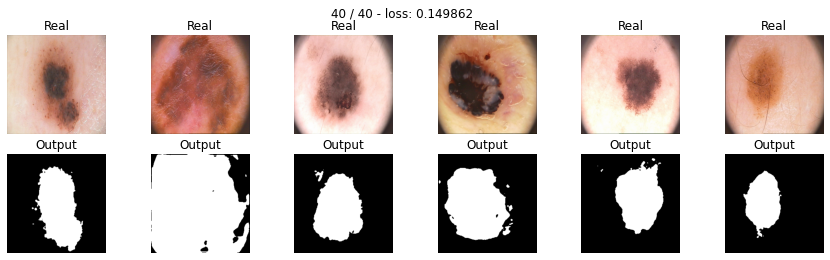

In [0]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 40, data_tr, data_val)

In [0]:
score_model(unet2_model, iou_pytorch, data_ts)

0.6800000468889872

Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [0]:
H_in = 32
padding = 4
dil = 3
k = 4
st = 2

H_out = (H_in + 2*padding - dil * (k-1) -1)/st + 1
print(H_out)

16.0


In [0]:
H_in = 128
padding = 3
dil = 2
k = 4
st = 2
out_padding = 1

H_out = (H_in - 1)* st - 2 * padding + dil * (k-1) + out_padding + 1
print(H_out)

256


In [0]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                      )
        self.pool0 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=4, dilation=3)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool1 = nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=4, dilation=3)  # 128 -> 64
        self.enc_conv2 =  nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, 3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, 3, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU())
        
        self.pool2 = nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=4, dilation=3)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.pool3 = nn.Conv2d(256, 256, kernel_size=4, stride=2, padding=4, dilation=3)  # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(256, 64, 1),
                                             nn.ReLU(),
                                             nn.Conv2d(64, 64, 3, padding=1),
                                             nn.ReLU(),
                                             nn.Conv2d(64, 256, 1))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=3, output_padding=1, dilation=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        
        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=3, output_padding=1, dilation=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=3, output_padding=1, dilation=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32, 32, 3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU())
        self.upsample3 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=3, output_padding=1, dilation=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16, 1, 3, padding=1))


    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)
        b = F.relu(b)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample1(d0)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample2(d1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample3(d2)
        d3 = self.dec_conv3(d3)  # no activation
        return d3

In [0]:
model = DilatedSegNet().to(device)

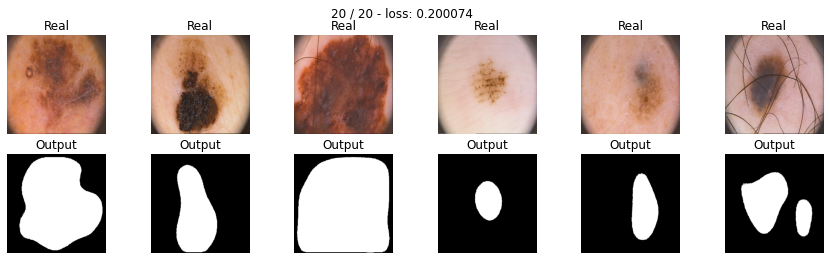

In [0]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, data_tr, data_val)

In [0]:
score_model(model, iou_pytorch,data_ts)

0.521666685740153

In [0]:
torch.cuda.empty_cache()

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



## Проведем обучение всех моделей со всеми фнкциями потерь.
Параметры:
  

*   Оптимайзер - ***AdamW***
*   learning rate - ***1e-5***
*   Кол-во эпох - ***100***





In [0]:
def train_2(model, opt, loss_fn, epochs, data_tr, data_val, data_ts):
    
    train_loss_history = []
    vall_loss_history = []
    score_test = []
    score_val = []

    for epoch in range(epochs):

        avg_loss = 0
        loss_val = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            #print(loss.item(), len(data_tr))
            avg_loss += loss.item() / len(data_tr)

        train_loss_history.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
          for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_hat = model(X_batch)
            loss_val += loss_fn(Y_batch, Y_hat).item()/len(data_val)
        vall_loss_history.append(loss_val)

        score_test.append(score_model(model, iou_pytorch, data_ts))
        score_val.append(score_model(model, iou_pytorch, data_val))

    return train_loss_history, vall_loss_history, score_test, score_val


In [0]:
def show_plot(title, loss_type, train_loss, val_loss, score_test, score_val):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('model architecture is \'{}\', loss function type is \'{}\''.format(title, loss_type))
  ax1.plot(list(range(1, 101)), train_loss, label='Train losses')
  ax1.plot(list(range(1, 101)), val_loss, label='Validation loss')
  ax1.set_title('Losses')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoches')
  ax1.legend()


  ax2.plot(list(range(1, 101)), score_val, label='Validation score')
  ax2.set_title('Scores')
  ax2.plot(list(range(1, 101)), score_test, label='Test score')
  ax2.set_ylabel('loss')
  ax2.legend()
  ax2.set_xlabel('epoches')
  ax2.set_ylabel('loss')

  plt.savefig('/content/drive/My Drive/SegmentHW/{}_{}'.format(title, loss_type))
  plt.show()

In [0]:
loss_fcn = { 'Tversky_loss': Tversky_loss, 'bce_loss': bce_loss,
             'dice_loss': dice_loss, 'focal_loss': focal_loss} 

In [0]:
max_epochs = 100
lr = 1e-5 

## SegNet

In [0]:
for loss in loss_fcn:

  model = SegNet().to(device)
  optimizer = optim.AdamW(model.parameters(), lr=lr)
  history = train_2(model, optimizer, loss_fcn[loss], max_epochs, data_tr, data_val, data_ts)
  show_plot('Segnet', loss, *history)
  history_pd = pd.DataFrame(history)
  history_pd = history_pd.T
  history_pd.columns = ['train_loss', 'val_loss', 'score_test', 'score_val']
  history_pd.to_csv('/content/drive/My Drive/SegmentHW/{}_{}.csv'.format('Segnet', loss))
 
torch.cuda.empty_cache()

![alt text](http://drive.google.com/uc?export=view&id=10RVj_y4SqHPI5tjwDUSYM_Uu1QTsi4x0)

![alt text](http://drive.google.com/uc?export=view&id=10WOP17oRM9JqoCQMf93mizyoGR-pS3oS)

![alt text](http://drive.google.com/uc?export=view&id=10fOJFbiqwqzcsZ1SFzf7z-x-Ve2l_f4w)

![alt text](http://drive.google.com/uc?export=view&id=10mgUYGVeAlkB7p0tWHKoFsQ07Ya44VZ5)

## Unet

In [0]:
loss_fcn = { 'Tversky_loss': Tversky_loss, 'bce_loss': bce_loss,
             'dice_loss': dice_loss, 'focal_loss': focal_loss}

for loss in loss_fcn:
  unet_model = UNet().to(device)
  optimizer = optim.AdamW(unet_model.parameters(), lr= lr)
  
  history = train_2(unet_model, optimizer, loss_fcn[loss], max_epochs, data_tr, data_val, data_ts)
  show_plot('Unet', loss, *history)
  history_pd = pd.DataFrame(history)
  history_pd = history_pd.T
  history_pd.columns = ['train_loss', 'val_loss', 'score_test', 'score_val']
  history_pd.to_csv('/content/drive/My Drive/SegmentHW/{}_{}.csv'.format('Unet', loss))
torch.cuda.empty_cache()

![alt text](http://drive.google.com/uc?export=view&id=10pKB-Ye5nPkeOzJf-X9fqkz-IVTyeZl8)

![alt text](http://drive.google.com/uc?export=view&id=10t5IeSHOk6X64W1EbjF9G--K6Bs8rR2r)

![alt text](http://drive.google.com/uc?export=view&id=10zrNbwFIvJ1yo5WzGwGp6N0-h2GCJ_RT)

![alt text](http://drive.google.com/uc?export=view&id=115tPF28oyvT_2BfUcNXWLoeAXHk2lf56)

## Unet 2

In [0]:
for loss in loss_fcn:  
  unet2_model = UNet2().to(device)
  optimizer = optim.AdamW(unet2_model.parameters(), lr= lr)

  history = train_2(unet2_model, optimizer, loss_fcn[loss], max_epochs, data_tr, data_val, data_ts)
  show_plot('Unet2', loss, *history)
  history_pd = pd.DataFrame(history)
  history_pd = history_pd.T
  history_pd.columns = ['train_loss', 'val_loss', 'score_test', 'score_val']
  history_pd.to_csv('/content/drive/My Drive/SegmentHW/{}_{}.csv'.format('Unet2', loss))
torch.cuda.empty_cache()

![alt text](http://drive.google.com/uc?export=view&id=11ITHePGKpALBYqa92gUqvRDTI5n5mksB)

![alt text](http://drive.google.com/uc?export=view&id=11N27GZfk_3c3q8CG1NduXKspAX5-za9E)

![alt text](http://drive.google.com/uc?export=view&id=11axtz2G9DjVkfUUX_UVrBocJzoBLaWlL)

![alt text](http://drive.google.com/uc?export=view&id=11otRuPsJe1W5ZgSJvZuzpOFPI_royXR_)

## DilatedSegNet

In [0]:

for loss in loss_fcn:
  model = DilatedSegNet().to(device)
  optimizer = optim.AdamW(model.parameters(), lr= lr)
  history = train_2(model, optimizer, loss_fcn[loss], max_epochs, data_tr, data_val, data_ts)
  show_plot('DilatedSegNet', loss, *history)
  history_pd = pd.DataFrame(history)
  history_pd = history_pd.T
  history_pd.columns = ['train_loss', 'val_loss', 'score_test', 'score_val']
  history_pd.to_csv('/content/drive/My Drive/SegmentHW/{}_{}.csv'.format('DilatedSegNet', loss))
torch.cuda.empty_cache()

![alt text](http://drive.google.com/uc?export=view&id=11zyXyFLsFyYTiBnWe2aaBJv5eKyLkgvQ)

![alt text](http://drive.google.com/uc?export=view&id=1273nGqkNX7HqsVRGPOlVTSaYOXTBQpEx)

![alt text](http://drive.google.com/uc?export=view&id=12DdsmSjlKGo6Q3xtiUxUxDO9GlBxrZ1B)

![alt text](http://drive.google.com/uc?export=view&id=12I7wEp4Ku5eRxkQxX-YcP1BBzPnvSqw7)

## Обработка полученных данных

In [0]:
import numpy as np
import pandas as pd
DilatedSegnet_Tv = pd.read_csv('/content/drive/My Drive/SegmentHW/DilatedSegNet_Tversky_loss.csv')
DilatedSegNet_bce = pd.read_csv('/content/drive/My Drive/SegmentHW/DilatedSegNet_bce_loss.csv')
DilatedSegNet_dice = pd.read_csv('/content/drive/My Drive/SegmentHW/DilatedSegNet_dice_loss.csv')
DilatedSegNet_focal = pd.read_csv('/content/drive/My Drive/SegmentHW/DilatedSegNet_focal_loss.csv')
Segnet_Tversky = pd.read_csv('/content/drive/My Drive/SegmentHW/Segnet_Tversky_loss.csv')
Segnet_bce = pd.read_csv('/content/drive/My Drive/SegmentHW/Segnet_bce_loss.csv')
Segnet_dice = pd.read_csv('/content/drive/My Drive/SegmentHW/Segnet_dice_loss.csv')
Segnet_focal = pd.read_csv('/content/drive/My Drive/SegmentHW/Segnet_focal_loss.csv')
Unet2_Tversky = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet2_Tversky_loss.csv')
Unet2_bce = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet2_bce_loss.csv')
Unet2_dice = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet2_dice_loss.csv')
Unet2_focal = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet2_focal_loss.csv')
Unet_Tversky = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet_Tversky_loss.csv')
Unet_bce = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet_bce_loss.csv')
Unet_dice = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet_dice_loss.csv')
Unet_focal = pd.read_csv('/content/drive/My Drive/SegmentHW/Unet_focal_loss.csv')

In [0]:
losses = ['Tversky_loss', 'bce_loss', 'dice_loss', 'focal_loss']
max_frame = pd.DataFrame(None, index=losses, columns=['SegNet', 'Unet', 'Unet2', 'DilatedSegNet'])

In [0]:

max_frame['DilatedSegNet'] = [DilatedSegnet_Tv['score_test'].max(), DilatedSegNet_bce['score_test'].max(),
                              DilatedSegNet_dice['score_test'].max(), DilatedSegNet_focal['score_test'].max()]
max_frame['SegNet'] = [Segnet_Tversky['score_test'].max(), Segnet_bce['score_test'].max(), 
                       Segnet_dice['score_test'].max(), Segnet_focal['score_test'].max()]
max_frame['Unet'] = [Unet_Tversky['score_test'].max(), Unet_bce['score_test'].max(),
                     Unet_dice['score_test'].max(), Unet_focal['score_test'].max()]
max_frame['Unet2'] = [Unet2_Tversky['score_test'].max(), Unet2_bce['score_test'].max(),
                      Unet2_dice['score_test'].max(), Unet2_focal['score_test'].max()]
max_model_score = max_frame.style.highlight_max(axis=0)
max_los_score = max_frame.style.highlight_max(axis=1)

In [0]:
from ipywidgets import interact

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#interact(T_1=(0, 3, 0.1), T_2=(0, 3, 0.1))

def filter(T_1, T_2, data):
  filtered_data = []
  step = 1
  input_data = data['val_loss'].to_numpy()
  filtered1_prev = input_data[0]
  filtered2_prev = input_data[0]
  for data in input_data:
    alpha_1 = T_1 / (T_1 + step)
    alpha_2 = T_2 / (T_2 + step)

    filtered1 = (1 - alpha_1) * data + alpha_1 * filtered1_prev
    filtered2 = (1 - alpha_2) * filtered1 + alpha_2 * filtered2_prev
    filtered_data.append(filtered2)
    filtered1_prev = filtered1
    filtered2_prev = filtered2
  return(filtered_data)
  '''plt.plot(filtered_data)
  plt.plot(input_data)
  plt.show()'''
# T_1 = 1.1; T_2 = 1.9

In [0]:
filteres_val_loss1 = [filter(1.1, 1.9, x) for x in [DilatedSegnet_Tv, DilatedSegNet_bce, DilatedSegNet_dice, DilatedSegNet_focal]]
filteres_val_loss2 = [filter(1.1, 1.9, x) for x in [Segnet_Tversky, Segnet_bce, Segnet_dice, Segnet_focal]]
filteres_val_loss3 = [filter(1.1, 1.9, x) for x in [Unet2_Tversky, Unet2_bce, Unet2_dice, Unet2_focal]]
filteres_val_loss4 = [filter(1.1, 1.9, x) for x in [Unet_Tversky, Unet_bce, Unet_dice, Unet_focal]]

## Выводы:

Отфильтруем значения функции потерь на валидации. Для этого будем использовать апериодическое звено второго порядка, при ***k*** (коэффициент усиления) равном ***1***:
\
\
\begin{equation} 
\frac{k}{(Ts + 1)^2}=\frac{\hat y}{y} \quad \quad \quad \quad(1)
\end{equation}
\
 Для расчета на дискретной сетке приведем (1) к виду (2), (3).\
 \
 $$\hat y_{1}(k)=(1-\alpha)\cdot y(k)+\alpha\cdot\hat y_{1}(k-1)\qquad\qquad(2)$$
 \
 $$\hat y_{2}(k)=(1-\alpha)\cdot\hat y_{1}(k)+\alpha\cdot\hat y_{2}(k-1) \qquad \quad(3)$$
 \
$$где,\quad\alpha =\frac{T}{T+h}$$ 

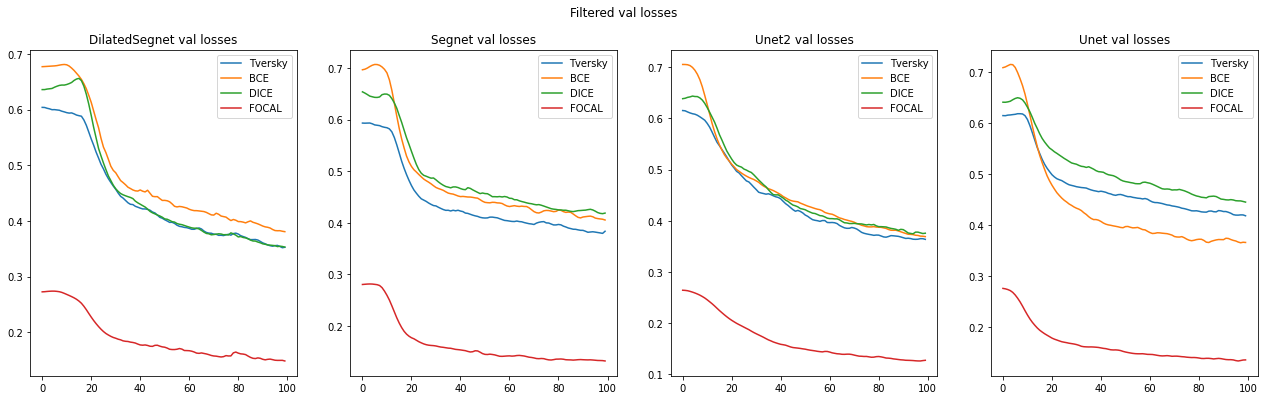

In [10]:
Plot_losses, ax = plt.subplots(1,4, figsize=(22, 6))
Plot_losses.suptitle('Filtered val losses')
ax[0].plot(filteres_val_loss1[0], label='Tversky')
ax[0].plot(filteres_val_loss1[1], label='BCE')
ax[0].plot(filteres_val_loss1[2], label='DICE')
ax[0].plot(filteres_val_loss1[3], label='FOCAL')

ax[1].plot(filteres_val_loss2[0], label='Tversky')
ax[1].plot(filteres_val_loss2[1], label='BCE')
ax[1].plot(filteres_val_loss2[2], label='DICE')
ax[1].plot(filteres_val_loss2[3], label='FOCAL')

ax[2].plot(filteres_val_loss3[0], label='Tversky')
ax[2].plot(filteres_val_loss3[1], label='BCE')
ax[2].plot(filteres_val_loss3[2], label='DICE')
ax[2].plot(filteres_val_loss3[3], label='FOCAL')

ax[3].plot(filteres_val_loss4[0], label='Tversky')
ax[3].plot(filteres_val_loss4[1], label='BCE')
ax[3].plot(filteres_val_loss4[2], label='DICE')
ax[3].plot(filteres_val_loss4[3], label='FOCAL')

ax[0].set_title('DilatedSegnet val losses')
ax[0].legend()
ax[1].set_title('Segnet val losses')
ax[1].legend()
ax[2].set_title('Unet2 val losses')
ax[2].legend()
ax[3].set_title('Unet val losses')
ax[3].legend()
plt.show()

При обучении модели ***Unet2*** потери на валидации при разных функциях потерь значения мало отличаются друг от друга. Значения функций потерь моделей ***SegNet*** и ***Unet*** быстрей минимизируются, чем на других моделей. 

In [34]:
max_los_score

,SegNet,Unet,Unet2,DilatedSegNet
Tversky_loss,0.506667,0.750833,0.685000,0.682500
bce_loss,0.690833,0.760833,0.755833,0.693333
dice_loss,0.690833,0.751667,0.671667,0.700833
focal_loss,0.714167,0.737500,0.770000,0.691667


In [36]:
max_frame.T.mean()

Tversky_loss    0.656250
bce_loss        0.725208
dice_loss       0.703750
focal_loss      0.728333
dtype: float64

***Focal loss*** и ***BCE loss*** показали самые высокие значения score на тестовой выборке.

In [32]:
max_model_score

,SegNet,Unet,Unet2,DilatedSegNet
Tversky_loss,0.506667,0.750833,0.685000,0.682500
bce_loss,0.690833,0.760833,0.755833,0.693333
dice_loss,0.690833,0.751667,0.671667,0.700833
focal_loss,0.714167,0.737500,0.770000,0.691667


In [35]:
max_frame.mean()

SegNet           0.650625
Unet             0.750208
Unet2            0.720625
DilatedSegNet    0.692083
dtype: float64

Модель ***Unet*** показала самые лучшие результаты на тестовой выборке.

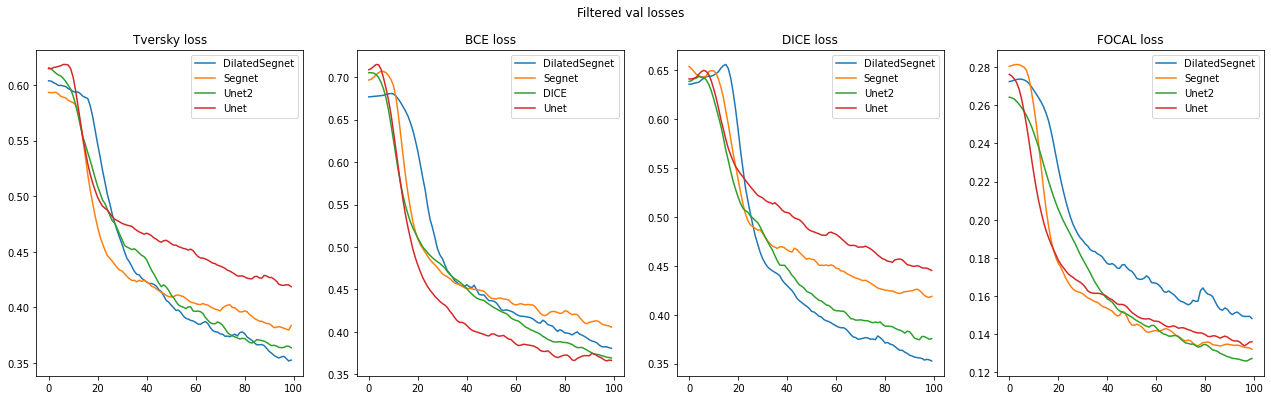

In [72]:
Plot_losses2, ax = plt.subplots(1,4, figsize=(22, 6))
Plot_losses2.suptitle('Filtered val losses')
ax[0].plot(filteres_val_loss1[0], label='DilatedSegnet')
ax[0].plot(filteres_val_loss2[0], label='Segnet')
ax[0].plot(filteres_val_loss3[0], label='Unet2')
ax[0].plot(filteres_val_loss4[0], label='Unet')

ax[1].plot(filteres_val_loss1[1], label='DilatedSegnet')
ax[1].plot(filteres_val_loss2[1], label='Segnet')
ax[1].plot(filteres_val_loss3[1], label='DICE')
ax[1].plot(filteres_val_loss4[1], label='Unet')

ax[2].plot(filteres_val_loss1[2], label='DilatedSegnet')
ax[2].plot(filteres_val_loss2[2], label='Segnet')
ax[2].plot(filteres_val_loss3[2], label='Unet2')
ax[2].plot(filteres_val_loss4[2], label='Unet')

ax[3].plot(filteres_val_loss1[3], label='DilatedSegnet')
ax[3].plot(filteres_val_loss2[3], label='Segnet')
ax[3].plot(filteres_val_loss3[3], label='Unet2')
ax[3].plot(filteres_val_loss4[3], label='Unet')

ax[0].set_title('Tversky loss')
ax[0].legend()
ax[1].set_title('BCE loss')
ax[1].legend()
ax[2].set_title('DICE loss')
ax[2].legend()
ax[3].set_title('FOCAL loss')
ax[3].legend()
plt.show()

Функция ***BCE loss*** показала более стабильную минимизацию, чем остальные.\
Несмотря на то, что самый высокий результат на тестовой выборке показала модель ***Unet2*** при функции ***focal loss***. Модель ***Unet*** и функция ***Dice loss*** показали лучшие результаты, чем другие не тесте. Также модель ***Unet*** обучается быстрей, чем остальные (кроме ***SegNet***) 